# RaJoLink workflow notebook demo based on Python script modules for LBD

RaJoLink is a method developed for **open** literature-based discovery (LBD). In contrast to Swanson's `ABC` model, RaJoLink focuses on a semi-automatic identification of candidates ($a$) that could be related to an investigated phenomenon ($c$). This selection is based on the identification of **rare terms** from the literature on $c$. At the heart of the RaJoLink strategy is the rational, unavoidable assumption that if literatures of multiple rare terms share a term in common, then that term becomes a candidate for term $a$.

The **RaJoLink** method comprises three main steps: **Ra**, **Jo**, and **Link**, which focus on rare terms, joint terms and linking terms, respectively. The Ra step searches the literature on phenomenon $C$ for unique or rare terms. The Jo step reviews articles related to these rare terms, and identifies joint terms (candidates for $a$) that appear in them, suggesting the hypothesis that $C$ is related to $A$. The Link step then looks for $b$-terms that bridge the literature on a selected $a$-term and $c$-term; $b$-terms are the candidates that can potentially explain the link.

The identification of rare terms in the Ra step is based on the statistical principle of outliers. Just as outliers in data can lead to significant discoveries, rare terms in the literature can pave the way for innovative connections. A term is considered rare if it occurs in $n$ or fewer data sets, where $n$ is adjustable depending on the experiment or context.

While Swanson's ABC model connects two disjoint literatures with term $b$, RaJoLink uses rare terms to generate term $a$, which bridges the literature with selected rare terms.

Note that in this particular implementation, the search for b-terms is limited to the [MeSH](https://www.nlm.nih.gov/mesh/meshhome.html) words for Enzymes and Coenzymes [D08] and Amino Acids, Peptides, and Proteins [D12], as selected by the domain expert.

Import and initialize `logging` library for tracing the scripts execution.

In [77]:
import logging

# Initialize logging with a basic configuration
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s: %(levelname)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

# logging.debug('This is a debug message')
# logging.info('This is an info message')
# logging.warning('This is a warning message')
# logging.error('This is an error message')
# logging.critical('This is a critical message')

Import LBD components from the framework notebooks. The purpose of the **import_ipynb** library is to enable the direct import of Jupyter Notebooks as modules, allowing code, functions, and classes defined in a notebook to be easily reused in other notebooks or python scripts.

In [78]:
import import_ipynb
import LBD_01_data_acquisition
import LBD_02_data_preprocessing
import LBD_03_feature_extraction
import LBD_04_text_mining
import LBD_05_results_analysis
import LBD_06_visualization

Import additional python libraries.

In [79]:
import nltk
import numpy as np
import itertools
import pandas as pd
# import pickle
# import json
import spacy
from typing import List, Dict

When running the script for the first time, `en_core_web_md`, which is a medium-sized English model trained on written web text (blogs, news, comments), has to be downloaded with the command:

```python
!python -m spacy download en_core_web_md
```

So, for the first run, you have to uncomment the first line in the next cell.

In [80]:
#!python -m spacy download en_core_web_md 

nlpr = spacy.load("en_core_web_md")

# Step Ra

In [81]:
# converting file to ascii helper
# LBD_01_data_acquisition.convert_file_to_ascii_encoding('input/214Texts.txt', 'input/214Texts_1.txt')

Define the name of the domain $C$ and load the responding text from the file. The expected file format is as follows:

1. The file is encoded in ascii or utf-8 standard.
2. Each line in the file represents one document. The words in each document are separated by spaces. Each document has a different length.
3. The first word in each line is the **unique id**, followed by a semicolon. Normally **pmid** (pubmed id) can be used for this purpose.
4. The second word in each line can optionally stand for a predefined domain (or class) of the document. In this case, the second word is preceded by **!**. For example, if the file contains documents that originate from two domains, e.g. *migraine* and *magnesium*, the second word in each line is either **!migraine** or **!magnesium**.
5. If the second word is not preceded by **!**, it is considered the first word of the document. In this case, the **!NA** (**not applicable** or **not available**) domain is assigned to the document.

In [82]:
domainName = 'Autism'
fileName = 'input/214Texts.txt'
lines = LBD_01_data_acquisition.load_data_from_file(fileName)
# display the first 7 lines of the document
lines[:7]

2024-08-19 20:32:00: INFO - Loaded 214 lines from "input/214Texts.txt".


['16911972: Assessing young children can be difficult, particularly when one considers the type of test behavior required for a psychological evaluation (Culbertson & Willis, 1993). Young children who are referred for a developmental evaluation because they appear to have features of autism can be particularly challenging, given their limited social interaction and communication skills (Marcus, Lansing, & Schopler, 1993; National Research Council, 2001). Many features and behavior problems can further interfere with the accurate assessment of a young child?s cognitive abilities, including difficulty maintaining attention, overactivity, sensory issues, and poor compliance, particularly in an unfamiliar setting. Young children with autism can be easily frustrated, and may not appear ?eager to please? due to their social difficulties or limited understanding of what is being asked of them. It is critical to identify cognitive strengths and weaknesses and developmental delays in the young 

In [83]:
# remove before publishing
#domainName = 'Demo'
#fileName = 'input/demo_2.txt'
#lines = LBD_01_data_acquisition.load_data_from_file(fileName)
#lines[:7]

In [84]:
# for testing purposes - remove later
#lines = LBD_01_data_acquisition.load_data_from_file("input/Migraine_before1988.txt")
#lines[:7]

In [85]:
# remove before publishing
# plato's dialogues
#lines = LBD_01_data_acquisition.load_data_from_file("input/plato_dialogues_ontogen.txt")
#lines[:7]

Load and preprocess MESH words for Enzymes and Coenzymes [D08] and Amino Acids, Peptides, and Proteins [D12]. The input file MESH_D08_D12.txt after the preprocessing contains 3534 words that are used in further preprocessing of autism files.

The next script is part of a pipeline designed to preprocess medical literature data, focusing on terms related to specific MeSH (Medical Subject Headings) categories. he purpose is to load and preprocess MESH words for Enzymes and Coenzymes [D08] and Amino Acids, Peptides, and Proteins [D12]. The input file MESH_D08_D12.txt was obtained by selecting relevant [D08] and [D12] terms from xml file `desc2024.xml` obtained from <a href="https://www.nlm.nih.gov/databases/download/mesh.html">MeSH web page</a>. The input file after the preprocessing contains 3534 words that are used as filer in further preprocessing of autism-related files.

*Functionality*

1. **Loading Data**:  
   The script starts by loading MeSH data from a specified file:
   ```python
   mesh_lines = LBD_01_data_acquisition.load_data_from_file("input/MESH_D08_D12.txt")
   ```
   This line reads the file `MESH_D08_D12.txt`, which likely contains textual data related to specific MeSH categories (D08 and D12), into a list of lines (`mesh_lines`). The function `load_data_from_file` handles the file reading, which is a crucial step in preparing the data for analysis.

2. **Dictionary Construction**:  
   The next step constructs a dictionary from the loaded lines:
   ```python
   mesh_docs_dict = LBD_02_data_preprocessing.construct_dict_from_list(mesh_lines)
   ```
   This transforms the list of lines into a dictionary (`mesh_docs_dict`), where keys may represent document identifiers and values hold the corresponding text. This structure is more efficient for subsequent text processing tasks.

3. **Document Preprocessing**:  
   The preprocessing phase is vital for cleaning and standardizing the textual data:
   ```python
   mesh_prep_docs_dict = LBD_02_data_preprocessing.preprocess_docs_dict(
       mesh_docs_dict, keep_list=[], remove_list=[], mesh_word_list=[], \
       cleaning=True, remove_stopwords=True, lemmatization=True, \
       min_word_length=5, keep_only_nouns=False, keep_only_mesh=False, stemming=False, stem_type=None)
   ```
   Here, various preprocessing techniques are applied:
   - **Cleaning**: General cleaning of the text.
   - **Stopword Removal**: Eliminating common words that do not contribute meaningful information (e.g., "the", "and").
   - **Lemmatization**: Reducing words to their base or root form (e.g., "running" becomes "run").
   - **Minimum Word Length**: Filtering out words shorter than five characters.
   These steps refine the data, ensuring it is suitable for further analysis and reducing noise.

4. **Extracting Preprocessed Documents**:  
   After preprocessing, the script extracts the cleaned text back into a list:
   ```python
   mesh_prep_docs_list = LBD_02_data_preprocessing.extract_preprocessed_documents_list(mesh_prep_docs_dict)
   ```
   This conversion is necessary for feature extraction, where the text needs to be in a list format.

5. **Feature Extraction (Bag of Words)**:  
   The final part of the script creates a Bag of Words (BoW) model:
   ```python
   mesh_word_list, mesh_bow_matrix = LBD_03_feature_extraction.create_bag_of_words(mesh_prep_docs_list, 1, 1)
   ```
   The BoW model is a fundamental text representation technique, where:
   - **`mesh_word_list`** contains the vocabulary—unique words identified in the documents.
   - **`mesh_bow_matrix`** is a matrix where each row corresponds to a document, and each column represents a word, with the matrix values indicating the frequency of words within the documents.

*Practical applications*

- **Biomedical Research**: Researchers can use this script to preprocess and analyze large datasets of medical literature, helping to identify new links between diseases, drugs, and biological processes.
- **Text Mining and NLP**: The script can be adapted for broader text mining tasks, such as sentiment analysis, topic modeling, or any domain requiring structured text representation.

*Usage*

To use this script in your workflow, ensure you have the appropriate data file (`MESH_D08_D12.txt`) and the modules for data acquisition, preprocessing, and feature extraction. After running the script, you'll obtain a vocabulary list and a corresponding BoW matrix, ready for further analysis.

In [86]:
mesh_lines = LBD_01_data_acquisition.load_data_from_file("input/MESH_D08_D12.txt")

mesh_docs_dict = LBD_02_data_preprocessing.construct_dict_from_list(mesh_lines)

keep_list = []
remove_list = []
mesh_prep_docs_dict = LBD_02_data_preprocessing.preprocess_docs_dict(
    mesh_docs_dict, keep_list = keep_list, remove_list = remove_list, mesh_word_list = [], \
    cleaning = True, remove_stopwords = True, lemmatization = True, \
    min_word_length = 5, keep_only_nouns = False, keep_only_mesh = False, stemming = False, stem_type = None)

mesh_prep_docs_list = LBD_02_data_preprocessing.extract_preprocessed_documents_list(mesh_prep_docs_dict)

mesh_word_list, mesh_bow_matrix = LBD_03_feature_extraction.create_bag_of_words(mesh_prep_docs_list, 1, 1)
print('Number of terms in MESH D08 and D12 vocabulary: ', len(mesh_word_list))

print(mesh_word_list.index('lactoylglutathione'))
print(mesh_word_list.index('calcium'))
print(mesh_word_list.index('channel'))
print(mesh_word_list.index('synaptophysin'))

print(mesh_word_list[:15])

2024-08-19 20:32:07: INFO - Loaded 1 lines from "input/MESH_D08_D12.txt".
2024-08-19 20:32:07: INFO - Text cleaning ...
2024-08-19 20:32:07: INFO - Removing stopwords ...
2024-08-19 20:32:07: INFO - Lematization ...
2024-08-19 20:32:07: INFO - Keeping only longer words ...
2024-08-19 20:32:07: INFO - Preprocessing finished.


Number of terms in MESH D08 and D12 vocabulary:  3534
1984
624
750
3216
['11betahydroxylase', '11betahydroxysteroid', '12alphahydroxylase', '12dioxygenase', '12lipoxygenase', '13betaglucosidase', '13reductase', '145trisphosphate', '14alphaglucan', '14alphaglucosidase', '14betacellobiosidase', '14betaglucosidase', '14demethylase', '1515monooxygenase', '15lipoxygenase']


Preprocess the domain documents stored in `lines` into a dictionary and then preprocess the documents using the obtained MeSH word list of Enzymes and Coenzymes [D08] and Amino Acids, Peptides, and Proteins [D12].

In [88]:
docs_dict = LBD_02_data_preprocessing.construct_dict_from_list(lines)

keep_list = []
remove_list = []
prep_docs_dict = LBD_02_data_preprocessing.preprocess_docs_dict(
    docs_dict, keep_list = keep_list, remove_list = remove_list, mesh_word_list = mesh_word_list, \
    cleaning = True, remove_stopwords = True, lemmatization = True, \
    min_word_length = 5, keep_only_nouns = False, keep_only_mesh = True, stemming = False, stem_type = None)

ids_list = LBD_02_data_preprocessing.extract_ids_list(prep_docs_dict)
prep_docs_list = LBD_02_data_preprocessing.extract_preprocessed_documents_list(prep_docs_dict)

2024-08-19 20:32:31: INFO - Text cleaning ...
2024-08-19 20:32:32: INFO - Removing stopwords ...
2024-08-19 20:32:32: INFO - Lematization ...
2024-08-19 20:32:33: INFO - Keeping only longer words ...
2024-08-19 20:32:33: INFO - Keeping only selected MeSH terms ...
2024-08-19 20:32:42: INFO - Preprocessing finished.


Display the first dictionary items, document (pubmed) ids and preprocessed documents. Then, display document `ids` and the first few preprocessed documents.
Observe the difference between the original and preprocessed document.

In [89]:
dict(itertools.islice(prep_docs_dict.items(), 7))

{'16911972': {'domain': 'NA',
  'document': 'Assessing young children can be difficult, particularly when one considers the type of test behavior required for a psychological evaluation (Culbertson & Willis, 1993). Young children who are referred for a developmental evaluation because they appear to have features of autism can be particularly challenging, given their limited social interaction and communication skills (Marcus, Lansing, & Schopler, 1993; National Research Council, 2001). Many features and behavior problems can further interfere with the accurate assessment of a young child?s cognitive abilities, including difficulty maintaining attention, overactivity, sensory issues, and poor compliance, particularly in an unfamiliar setting. Young children with autism can be easily frustrated, and may not appear ?eager to please? due to their social difficulties or limited understanding of what is being asked of them. It is critical to identify cognitive strengths and weaknesses and d

In [90]:
ids_list[:7]

['16911972',
 '16835068',
 '16816240',
 '16770606',
 '16722615',
 '16709250',
 '16703115']

In [91]:
prep_docs_list[:7]

['require interaction sensory delay disorder information associate disorder disorder three disorder pattern require disorder mental mental common common early alternative motor motor delay specific group relate group determine group group group early initiation group brain motor group disorder delay early group group group motor three group group group group short group group group group group group group relate group group group constant group reduce delay require delay werner early early regulate early activity require block require require function early program determine function group group delay determine specific delay specific disorder design determine response early motor relate combination early motor motor early response sense function potential',
 'disorder interaction large abnormal period disorder disorder syndrome disorder disorder mental retardation fragile tuberous sclerosis syndrome gastrointestinal common early disorder factor determine disorder specific factor assoc

Generate bag-of-words matrix from the list of preprocessed documents. Remove n-gram words that occur less than *min_ngram_count* times (3 in our case) in the whole corpus of documents. Remove also the words that are not pressent in the MESH list *mesh_word_list*.

This script is a continuation of the feature extraction process, focusing on refining a Bag of Words (BoW) model by filtering out less significant terms and n-grams. It generates a bag-of-words matrix from the list of preprocessed documents. Then it removes n-gram words that occur less than *min_ngram_count* times (3 in our case) in the whole corpus of documents. It removes also the words that are not pressent in the MESH list *mesh_word_list*. This step is essential for improving the quality and relevance of the text representation by reducing the vocabulary size for more efficient (time) execution of the following steps.

*Functionality*

1. **Setting Parameters**:  
   The script begins by defining the parameters for n-gram size and minimum document frequency:
   ```python
   ngram_size = 2
   min_df = 1
   ```
   - **`ngram_size`**: Specifies that the model will consider pairs of consecutive words (bigrams) as features.
   - **`min_df`**: Sets the minimum number of documents a word or n-gram must appear in to be included in the initial vocabulary.

2. **Creating Bag of Words Representation**:  
   The next step generates the BoW model using the specified n-gram size:
   ```python
   word_list, bow_matrix = LBD_03_feature_extraction.create_bag_of_words(prep_docs_list, ngram_size, min_df)
   print('Number of terms in initial vocabulary with all n-grams: ', len(word_list))
   ```
   This function creates a vocabulary (`word_list`) of all terms and n-grams found in the preprocessed documents (`prep_docs_list`), along with their corresponding frequency matrix (`bow_matrix`). The initial vocabulary includes all n-grams without filtering.

3. **Filtering Low-Frequency N-Grams**:  
   The script then filters out n-grams that occur less frequently than a specified threshold:
   ```python
   min_count_ngram = 3
   tmp_sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)
   tmp_sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)
   ```
   - **`min_count_ngram`**: Sets the minimum occurrence count for n-grams to be retained.
   - The script calculates two key metrics:
     - **Document Frequency**: How many documents contain each word or n-gram.
     - **Total Frequency**: How often each word or n-gram appears across all documents.

4. **Filtering Based on Specific Criteria**:  
   The script applies a more sophisticated filtering process to refine the vocabulary:
   ```python
   tmp_filter_columns = []
   for i, word in enumerate(word_list):
       if not LBD_03_feature_extraction.word_is_nterm(word):
           if word in mesh_word_list:
               tmp_filter_columns.append(i)
       else:
           if tmp_sum_count_word_in_docs[word] >= min_count_ngram:
               check_ngram = word.split()
               passed = True
               for check_word in check_ngram:
                   if check_word not in mesh_word_list:
                       passed = False
               if check_ngram[0] == check_ngram[1]:
                   passed = False
               if passed:
                   tmp_filter_columns.append(i)
   ```
   This loop evaluates each term or n-gram in the vocabulary:
   - **Non-n-grams**: Retained only if they are present in a predefined `mesh_word_list`.
   - **N-Grams**: Retained if:
     - They meet the minimum frequency criteria.
     - All component words are in `mesh_word_list`.
     - The n-gram does not consist of repeated words (e.g., "word word").

5. **Applying the Filters**:  
   The script then filters both the rows and columns of the BoW matrix:
   ```python
   tmp_filter_rows = []
   for i, id in enumerate(ids_list):
       tmp_filter_rows.append(i)

   tmp_filtered_word_list, tmp_filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix_columns(
       word_list, bow_matrix, tmp_filter_rows, tmp_filter_columns)

   word_list = tmp_filtered_word_list
   bow_matrix = tmp_filtered_bow_matrix
   print('Number of terms in preprocessed vocabulary after removing infrequent n-grams and non MESH words: ', len(word_list))
   ```
   - **`filter_matrix_columns`**: Refines the BoW matrix by keeping only the selected words or n-grams that passed the filtering criteria.
   - The updated vocabulary and matrix are then stored back in `word_list` and `bow_matrix`, respectively.

*Applications*

- **Medical Text Mining**: This filtering process is particularly useful in medical research, where the focus is on extracting and analyzing relevant biomedical terms and concepts.
- **Document Classification**: By refining the feature set, this script can improve the performance of classifiers used in categorizing scientific literature or other text corpora.
- **Network Analysis**: The filtered vocabulary can serve as nodes in a network graph, representing meaningful terms and their co-occurrences, which can be analyzed to identify hidden connections.

*Usage*

To use this script effectively, ensure you have a preprocessed document list (`prep_docs_list`) and a list of MeSH terms (`mesh_word_list`). Adjust the parameters like `ngram_size`, `min_df`, and `min_count_ngram` according to your specific needs. After running the script, you will obtain a filtered vocabulary and a corresponding BoW matrix, which are more suited for further analysis, such as clustering, topic modeling, or discovering novel hypotheses in biomedical research.

In n-grams, all the words must be in mesh.

In [113]:
ngram_size = 2
min_df = 1
keep_only_mesh_II = True

# BOW representation
word_list, bow_matrix = LBD_03_feature_extraction.create_bag_of_words(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary with all n-grams: ', len(word_list))

# remove nterms with frequency count less than min_count_ngram from vocabulary word_list and bow_matrix
min_count_ngram = 3
tmp_sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

tmp_sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

tmp_filter_columns = []
for i, word in enumerate(word_list):
    if not LBD_03_feature_extraction.word_is_nterm(word):
        if (not keep_only_mesh_II) or (word in mesh_word_list):
            tmp_filter_columns.append(i)
    else:
        if tmp_sum_count_word_in_docs[word] >= min_count_ngram:
            check_ngram = word.split()
            passed = True
            for check_word in check_ngram:
                if keep_only_mesh_II:
                    if check_word not in mesh_word_list:
                        passed = False
            if check_ngram[0] == check_ngram[1]:
                passed = False
            # passed = True
            if passed:
                tmp_filter_columns.append(i)

tmp_filter_rows = []
for i, id in enumerate(ids_list):
    tmp_filter_rows.append(i)

tmp_filtered_word_list, tmp_filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, bow_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
bow_matrix = tmp_filtered_bow_matrix

kom_text = ''
if keep_only_mesh_II:
    kom_text = ' and non-MeSH words'
print('Number of terms in preprocessed vocabulary after removing infrequent n-grams', kom_text, ': ', len(word_list), sep='')

LBD_02_data_preprocessing.save_list_to_file(word_list, "output/_list.txt")
LBD_02_data_preprocessing.save_list_to_file(prep_docs_list, "output/_prep_list.txt")


Number of terms in initial vocabulary with all n-grams:  15238
Number of terms in preprocessed vocabulary after removing infrequent n-grams and non MeSH words: 3991


This script is a continuation of the text preprocessing pipeline, computing margins for Bag of Words (BoW) matrix and optimizing the BoW matrix for better interpretability and analysis. By rearranging the matrix to emphasize the most significant terms and documents, this script aids in revealing patterns in the data, which is a crucial step in LBD.

*Functionality*

1. **Counting Word Frequencies**:
   The script begins by calculating various frequency counts that provide insight into how words are distributed across documents:
   ```python
   sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)
   sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)
   sum_count_words_in_doc = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, bow_matrix)
   ```
   - **`sum_count_docs_containing_word`**: Counts how many documents each word appears in.
   - **`sum_count_word_in_docs`**: Totals the occurrences of each word across all documents.
   - **`sum_count_words_in_doc`**: Tallies the total number of words in each document.

   These metrics are essential for understanding the significance and distribution of terms within the corpus, which can guide further analysis.

2. **Displaying Frequency Counts**:
   The script then prints a subset of these frequency counts to give an overview of the data:
   ```python
   print('Number of documents in which each word is present: ', dict(itertools.islice(sum_count_docs_containing_word.items(), 7)))
   print('Number of occurrences of each word in all documents: ', dict(itertools.islice(sum_count_word_in_docs.items(), 7)))
   print('Number of words in each document: ', dict(itertools.islice(sum_count_words_in_doc.items(), 7)))
   ```
   - **`islice`** from `itertools` is used to print just the first few items, making it easier to inspect the data without overwhelming output.
   - These print statements help users quickly assess the distribution and frequency of words and documents in the BoW model.

3. **Optimizing the BoW Matrix**:
   The script proceeds to rearrange the BoW matrix so that the most frequent words and documents are positioned at the top-left corner of the matrix:
   ```python
   filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
       LBD_02_data_preprocessing.sort_dict_by_value(sum_count_word_in_docs, reverse=True), word_list)
   filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
       LBD_02_data_preprocessing.sort_dict_by_value(sum_count_words_in_doc, reverse=True), ids_list)
   ```
   - **Sorting**: The words and documents are sorted by their frequencies in descending order.
   - **Filtering**: The indices of these sorted words and documents are then used to rearrange the BoW matrix.

   This step ensures that the most significant terms and documents are easily accessible, facilitating further analysis such as clustering, topic modeling, or visualization.

4. **Rearranging the Matrix**:
   Finally, the script filters the matrix according to the computed order:
   ```python
   filtered_ids_list, filtered_word_list, filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix(
       ids_list, word_list, bow_matrix, filter_rows, filter_columns)
   ```
   - **`filter_matrix`**: This function reorders the BoW matrix based on the sorted indices, ensuring that the most relevant terms and documents are emphasized.

   The script then prints out the first few items in the reordered lists:
   ```python
   print('The first few documents in the rows of the filtered bow matrix: ', filtered_ids_list[:7])
   print('The first few words in the columns of the filtered bow matrix: ', filtered_word_list[:7])
   ```
   - This output allows users to verify that the matrix has been rearranged as intended, highlighting the most important elements of the dataset.

*Usage*

To use this script, ensure you have a BoW matrix (`bow_matrix`) and associated lists of words (`word_list`) and document IDs (`ids_list`). The script will process these inputs to compute frequency counts, reorder the matrix, and then output the rearranged BoW matrix. This optimized matrix can be used in various downstream tasks, such as creating visualizations, conducting deeper statistical analysis, or feeding into machine learning models for predictive tasks.

In [93]:
sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

sum_count_words_in_doc = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, bow_matrix)

print('Number of documents in which each word is present: ', dict(itertools.islice(sum_count_docs_containing_word.items(), 7)))
print('Number of occurences of each word in all documents: ', dict(itertools.islice(sum_count_word_in_docs.items(), 7)))
print('Number of words in each document: ', dict(itertools.islice(sum_count_words_in_doc.items(), 7)))

# Compute the order of rows (documents) and columns (words) in the bow matrix so that the most frequent words are in the top-left corner. 
filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_word_in_docs, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_words_in_doc, reverse=True), ids_list) 

# Rearange (filter) the bow matrix according to the previously computed order.
filtered_ids_list, filtered_word_list, filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, bow_matrix, filter_rows, filter_columns)
print('The first few documents in the rows of the filtered bow matrix: ', filtered_ids_list[:7])
print('The first few words in the columns of the filtered bow matrix: ', filtered_word_list[:7])

Number of documents in which each word is present:  {'2microglobulin': 1, '4hydroxylase': 1, '5ht1a': 1, '5ht1a receptors': 1, '5ht1b': 1, '5ht2a': 1, '5hydroxytryptophan': 1}
Number of occurences of each word in all documents:  {'2microglobulin': 1, '4hydroxylase': 1, '5ht1a': 4, '5ht1a receptors': 3, '5ht1b': 1, '5ht2a': 1, '5hydroxytryptophan': 2}
Number of words in each document:  {'16911972': 166, '16835068': 473, '16816240': 99, '16770606': 317, '16722615': 517, '16709250': 622, '16703115': 324}
The first few documents in the rows of the filtered bow matrix:  ['10727395', '16262991', '16262984', '12555918', '16467917', '15138176', '16251272']
The first few words in the columns of the filtered bow matrix:  ['group', 'disorder', 'response', 'function', 'three', 'sequence', 'brain']


Visualize bag-of-words matrix.

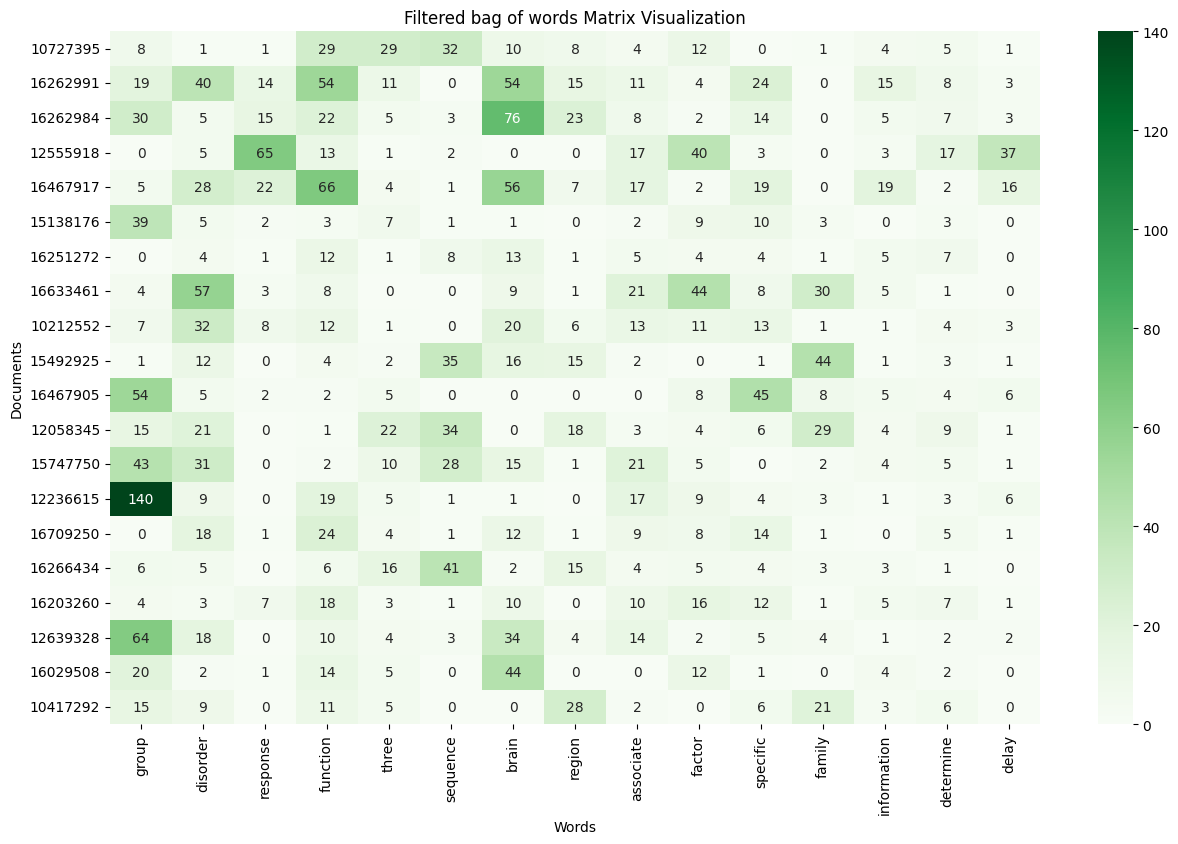

In [94]:
first_row = 0
last_row = 20
first_column = 0
last_column = 15
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered bag of words', \
                                           filtered_bow_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], \
                                           filtered_word_list[first_column:last_column], as_int = True)

Generate tf-idf matrix from the list of preprocessed documents.

In [95]:
# TF-IDF representation
word_list, tfidf_matrix = LBD_03_feature_extraction.create_tfidf(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary with all n-grams: ', len(word_list))
# print(word_list)
# print(tfidf_matrix)

# Rearange (filter) the tfidf matrix according to the previously computed order from bow matrix.
tmp_filtered_word_list, tmp_filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, tfidf_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
tfidf_matrix = tmp_filtered_tfidf_matrix
print('Number of terms in preprocessed vocabulary after removing infrequent n-grams and non MESH words: ', len(word_list))

Number of terms in initial vocabulary with all n-grams:  15238
Number of terms in preprocessed vocabulary after removing infrequent n-grams and non MESH words:  3991


Compute margins for tf-idf matrix.

In [96]:
sum_word_tfidf = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, tfidf_matrix)
max_word_tfidf = LBD_03_feature_extraction.max_tfidf_each_word_in_all_documents(word_list, tfidf_matrix)

sum_doc_tfidf = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, tfidf_matrix)
max_doc_tfidf = LBD_03_feature_extraction.max_tfidf_all_words_in_each_document(ids_list, tfidf_matrix)

print('Sum of tfidf for each word: ', dict(itertools.islice(sum_word_tfidf.items(), 7)))
print('Max of tfidf for each word: ', dict(itertools.islice(max_word_tfidf.items(), 7)))

print('Sum of tfidf for each document: ', dict(itertools.islice(sum_doc_tfidf.items(), 7)))
print('Max of tfidf for each document: ', dict(itertools.islice(max_doc_tfidf.items(), 7)))

# Compute the order of rows (documents) and columns (words) in the tfidf matrix so that the most important words are in the top-left corner. 
filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_doc_tfidf, reverse=True), ids_list) 

# Rearange (filter) the bow matrix according to the previously computed order.
filtered_ids_list, filtered_word_list, filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, tfidf_matrix, filter_rows, filter_columns)

Sum of tfidf for each word:  {'2microglobulin': 0.02830402626821874, '4hydroxylase': 0.010821867599786088, '5ht1a': 0.06854368722857791, '5ht1a receptors': 0.05140776542143343, '5ht1b': 0.017135921807144478, '5ht2a': 0.029787415239302308, '5hydroxytryptophan': 0.034271843614288956}
Max of tfidf for each word:  {'2microglobulin': 0.02830402626821874, '4hydroxylase': 0.010821867599786088, '5ht1a': 0.06854368722857791, '5ht1a receptors': 0.05140776542143343, '5ht1b': 0.017135921807144478, '5ht2a': 0.029787415239302308, '5hydroxytryptophan': 0.034271843614288956}
Sum of tfidf for each document:  {'16911972': 5.522855396398783, '16835068': 10.450876900558278, '16816240': 5.693477794681375, '16770606': 8.61111316103656, '16722615': 8.327592437231832, '16709250': 11.16581350025962, '16703115': 5.54788796419041}
Max of tfidf for each document:  {'16911972': 0.5409945558443113, '16835068': 0.27884093127774645, '16816240': 0.389002887159674, '16770606': 0.36677623311935725, '16722615': 0.5522127

Visualize tf-idf matrix.

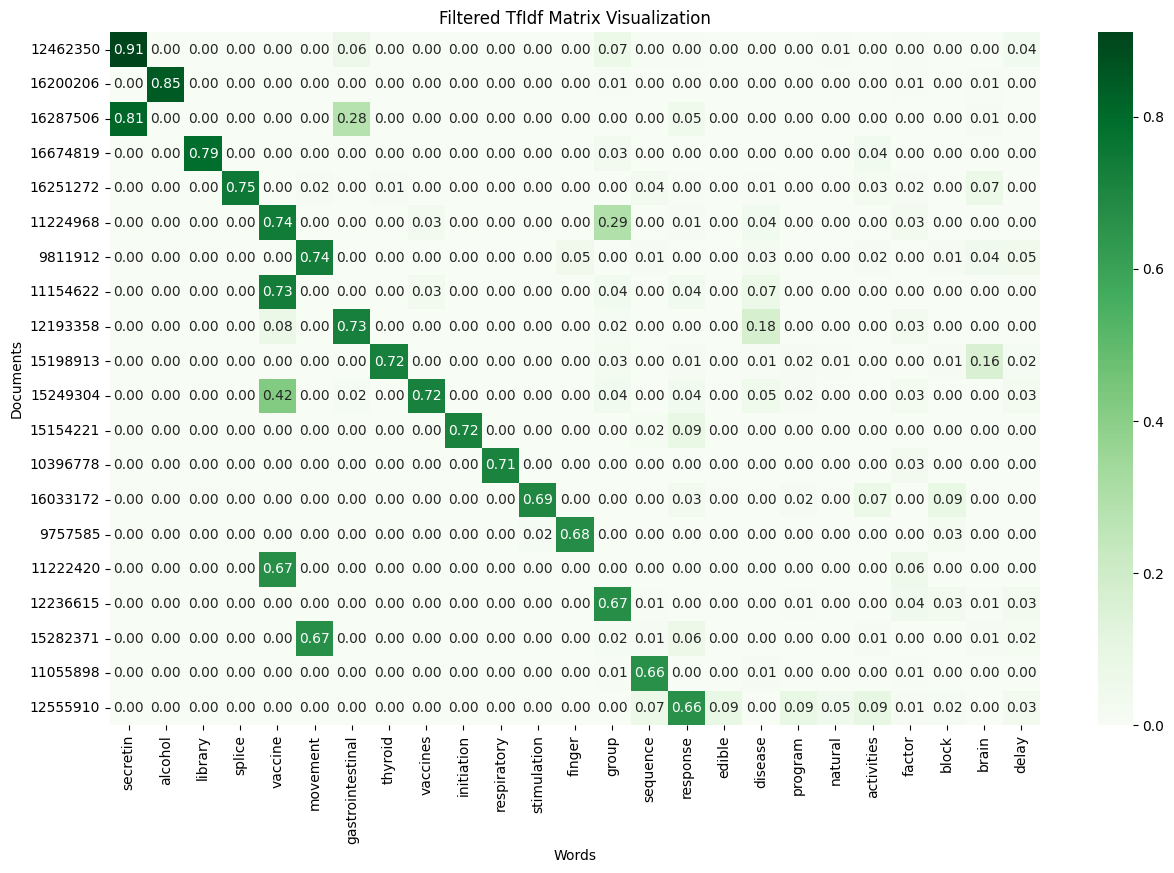

In [97]:
first_row = 0
last_row = 20
first_column = 0
last_column = 25
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered TfIdf', filtered_tfidf_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], filtered_word_list[first_column:last_column], as_int = False)

Generate a list of the domain names of all the documents and a list of unique domain names.

In [98]:
domains_list = LBD_02_data_preprocessing.extract_domain_names_list(docs_dict)
print('Domain names for the first few documents: ', domains_list[:7])
unique_domains_list = LBD_02_data_preprocessing.extract_unique_domain_names_list(prep_docs_dict)
print('A list of all uniques domain names in all the documents: ', unique_domains_list)


Domain names for the first few documents:  ['NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA']
A list of all uniques domain names in all the documents:  ['NA']


Visualize the documents in 2D graph by reducing the dimensionality of tfidf matrix with PCA.

In [99]:
type(tfidf_matrix)
print(tfidf_matrix[:7,:7])
print(tfidf_matrix.shape)
print(len(ids_list))
print(len(domains_list))
print(len(word_list))

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
(214, 3991)
214
214
3991


In [100]:
LBD_06_visualization.visualize_tfidf_pca_interactive(ids_list, domains_list, tfidf_matrix, transpose = False)

In [101]:
from sklearn.cluster import KMeans

# Cluster the documents using KMeans
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(tfidf_matrix)
cluster_assignments = list(np.asarray(kmeans.labels_))
cluster_assignments = [str(i) for i in cluster_assignments]
type(cluster_assignments)

c:\Work\LBD_book\venv\lib\site-packages\sklearn\utils\validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



list

In [102]:
LBD_06_visualization.visualize_tfidf_pca_interactive(ids_list, cluster_assignments, tfidf_matrix, transpose = False)

In [103]:
domains_list = [LBD_02_data_preprocessing.strDomainDefault]*len(word_list)
LBD_06_visualization.visualize_tfidf_pca_interactive(word_list, domains_list, tfidf_matrix, transpose = True)

Generate a list of *rare* words. Use the max value of word tf-idf for sorting the list of rare words.

TODO: describe the criterion for rare term selection

In [104]:
print("Dictionary of words, count and max(tfidf):")

max_word_tfidf_selected = {}
for word in max_word_tfidf.keys():
    if sum_count_docs_containing_word[word] <= 1:
        max_word_tfidf_selected[word] = max_word_tfidf[word]
         
import itertools
print('All the words in vocabulary: ', len(max_word_tfidf))
print('Selected rare words: ', len(max_word_tfidf_selected), ' ', dict(itertools.islice(max_word_tfidf_selected.items(), 30)))

max_word_tfidf_selected_sorted = LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf_selected, True)

print('Sorted rare words: ', len(max_word_tfidf_selected_sorted), ' ', dict(itertools.islice(max_word_tfidf_selected_sorted.items(), 30)))
print('First and last sorted rare word: ', list(max_word_tfidf_selected_sorted.items())[0], ' ', list(max_word_tfidf_selected_sorted.items())[-1])
print('Mean value of max tfidf values: ', np.array(list(max_word_tfidf_selected_sorted.values())).mean())

Dictionary of words, count and max(tfidf):
All the words in vocabulary:  3991
Selected rare words:  495   {'2microglobulin': 0.02830402626821874, '4hydroxylase': 0.010821867599786088, '5ht1a': 0.06854368722857791, '5ht1a receptors': 0.05140776542143343, '5ht1b': 0.017135921807144478, '5ht2a': 0.029787415239302308, '5hydroxytryptophan': 0.034271843614288956, '5lipoxygenase': 0.03298331694574479, '5lipoxygenaseactivating': 0.03298331694574479, 'acceptor splice': 0.08394997767847819, 'accessory': 0.044742361213634466, 'acetylcholine': 0.09840346618166053, 'acetylcholinesterase': 0.06607751101593906, 'acidbinding': 0.014451052764701454, 'activate blood': 0.052843367755360776, 'activate neuronal': 0.07045782367381437, 'activate region': 0.08050961675949624, 'activate regions': 0.06440769340759699, 'activation general': 0.06440769340759699, 'activation plasma': 0.052843367755360776, 'activators': 0.03854297899401359, 'activity contain': 0.11125158466162871, 'activity essential': 0.0324656027

Determine three rare terms for further analysis

In [105]:
rare_terms_list = list(max_word_tfidf_selected_sorted.keys())
rare_terms_list_length = len(rare_terms_list)

df = pd.DataFrame({'Rare term': rare_terms_list, 'max tfidf': list(max_word_tfidf_selected_sorted.values())})
df[0:25]

,Rare term,max tfidf
0,gliadin,0.513029
1,vancomycin,0.484120
2,finger sensory,0.367959
3,function transfer,0.357635
4,antimicrobial,0.322746
5,facilitative,0.297257
6,sensory finger,0.294367
7,interaction block,0.285611
8,vancomycin antimicrobial,0.242060
9,plasma virus,0.228988


In [106]:
term_display_first = 0
term_display_length = 400 # 75
print('Length: ', rare_terms_list_length, ', starting with: ', term_display_first)
for i in range(term_display_first, term_display_first+term_display_length):
    if i < rare_terms_list_length:
        term = rare_terms_list[i]
        print(i, ' ', term, ' ', max_word_tfidf_selected_sorted[term])

Length:  495 , starting with:  0
0   gliadin   0.5130293933278904
1   vancomycin   0.4841195559961404
2   finger sensory   0.3679589346207297
3   function transfer   0.3576350155468361
4   antimicrobial   0.3227463706640936
5   facilitative   0.2972571701342
6   sensory finger   0.2943671476965838
7   interaction block   0.2856112095880443
8   vancomycin antimicrobial   0.2420597779980702
9   plasma virus   0.22898792693989672
10   gastrointestinal disease   0.2283942228686198
11   induce recognition   0.226152943345149
12   natural combine   0.22548537567411753
13   subtype group   0.22409315022200135
14   class member   0.20308647178144504
15   gliadin peptides   0.2007506321717832
16   basic shock   0.19597181523922264
17   early maturation   0.1944984243584932
18   brain thyroid   0.19147605633233028
19   thyroid hormone   0.19147605633233028
20   disease gastrointestinal   0.19032851905718318
21   glutamate receptors   0.18851481998517167
22   neuropeptide hormones   0.18598779326

In [107]:
name = 'calcium channel'
print(name, ': ', 'position in the list of rare terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

calcium channel: position in the list of rare terms 38 (495), max tfidf: 0.157


In [108]:
name = 'synaptophysin'
print(name, ': ', 'position in the list of rare terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

synaptophysin: position in the list of rare terms 37 (495), max tfidf: 0.159


In [109]:

name = 'lactoylglutathione'
print(name, ': ', 'position in the list of rare terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

lactoylglutathione: position in the list of rare terms 377 (495), max tfidf: 0.031


In the last part of the step Ra we have identified three rare terms for further exploration: 

* *calcium channel*, 
* *synaptophysin*, 
* and *lactoylglutathione*.

# Step Jo

How the input files were prepared?

In [ ]:
fileName = 'input/f_calcium_channels.txt'
lines = LBD_01_data_acquisition.load_data_from_file(fileName)
lines[:7]

In [ ]:
fileName = 'input/f_synaptophysin.txt'
lines2 = LBD_01_data_acquisition.load_data_from_file(fileName)
lines2[:7]

In [ ]:
fileName = 'input/f_lactoylglutathione.txt'
lines3 = LBD_01_data_acquisition.load_data_from_file(fileName)
lines3[:7]

Combine all three input texts to a sinlge list.

In [ ]:
lines.extend(lines2)
lines.extend(lines3)
len(lines)

Preprocess the list of input documents.

In [ ]:
docs_dict = LBD_02_data_preprocessing.construct_dict_from_list(lines)

keep_list = []
remove_list = []
prep_docs_dict = LBD_02_data_preprocessing.preprocess_docs_dict(
    docs_dict, keep_list = keep_list, remove_list = remove_list, mesh_word_list = mesh_word_list, \
    cleaning = True, remove_stopwords = True, lemmatization = True, \
    min_word_length = 5, keep_only_nouns = True, keep_only_mesh = True, stemming = False, stem_type = None)

# 

ids_list = LBD_02_data_preprocessing.extract_ids_list(prep_docs_dict)
domains_list = LBD_02_data_preprocessing.extract_domain_names_list(prep_docs_dict)
unique_domains_list = LBD_02_data_preprocessing.extract_unique_domain_names_list(prep_docs_dict)
prep_docs_list = LBD_02_data_preprocessing.extract_preprocessed_documents_list(prep_docs_dict)

In [ ]:
dict(itertools.islice(prep_docs_dict.items(), 7))

Generate Bag of Words matrix.

In [ ]:
ngram_size = 1
min_df = 1

# BOW representation
word_list, bow_matrix = LBD_03_feature_extraction.create_bag_of_words(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary: ', len(word_list))
# print(word_list)
# print(bow_matrix)

# remove nterms with frequency count less than min_count_ngram from vocabulary word_list and bow_matrix
min_count_ngram = 3
tmp_sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

tmp_sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

tmp_filter_columns = []
for i, word in enumerate(word_list):
    if not LBD_03_feature_extraction.word_is_nterm(word):
        if word in mesh_word_list:
            tmp_filter_columns.append(i)
    else:
        if tmp_sum_count_word_in_docs[word] >= min_count_ngram:
            check_ngram = word.split()
            passed = True
            for check_word in check_ngram:
                if check_word not in mesh_word_list:
                    passed = False
            if check_ngram[0] == check_ngram[1]:
                passed = False
            # passed = True
            if passed:
                tmp_filter_columns.append(i)

# keep the original order of rows
tmp_filter_rows = []
for i, id in enumerate(ids_list):
    tmp_filter_rows.append(i)

tmp_filtered_word_list, tmp_filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, bow_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
bow_matrix = tmp_filtered_bow_matrix
print('Number of terms in preprocessed vocabulary: ', len(word_list))


In [ ]:
# Generate domains_bow_matrix from bow_matrix using domain_names list to add bow_matrix rows for each unique domain name into a single row
domains_bow_matrix = np.empty((0, bow_matrix.shape[1]))
for i, domain_name in enumerate(unique_domains_list):
    domain_docs_indices = [i for i, label in enumerate(domains_list) if label == domain_name]
    print(domain_docs_indices[:7])
    tmp = (bow_matrix[domain_docs_indices,:]).sum(axis=0)
    print(i, tmp)
    domains_bow_matrix = np.vstack((domains_bow_matrix, tmp))
    # Compute centroid for the current cluster
    #centroid_x = np.mean(pca_result[cluster_docs_indices, 0])
    #centroid_y = np.mean(pca_result[cluster_docs_indices, 1])
print(domains_bow_matrix)

In [ ]:
def cell_value_in_bow_matrix(bow_matrix, domain_name, word):
    """
    """
    line_idx = unique_domains_list.index(domain_name)
    column_idx = word_list.index(word)
    return(bow_matrix[line_idx, column_idx])

cell_value_in_bow_matrix(domains_bow_matrix, unique_domains_list[0], word_list[0])


In [ ]:
sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

sum_count_words_in_doc = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, bow_matrix)

print(dict(itertools.islice(sum_count_docs_containing_word.items(), 7)))
print(dict(itertools.islice(sum_count_word_in_docs.items(), 7)))
print(dict(itertools.islice(sum_count_words_in_doc.items(), 7)))

filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_word_in_docs, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_words_in_doc, reverse=True), ids_list) 

filtered_ids_list, filtered_word_list, filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, bow_matrix, filter_rows, filter_columns)
print(filtered_ids_list[:7])

In [ ]:
first_row = 0
last_row = 20
first_column = 0
last_column = 15
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered bag of words', \
                                           filtered_bow_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], \
                                           filtered_word_list[first_column:last_column], as_int = True)

In [ ]:
# TF-IDF representation
word_list, tfidf_matrix = LBD_03_feature_extraction.create_tfidf(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary: ', len(word_list))
# print(word_list)
# print(tfidf_matrix)

tmp_filtered_word_list, tmp_filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, tfidf_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
tfidf_matrix = tmp_filtered_tfidf_matrix
print('Number of terms in preprocessed vocabulary: ',len(word_list))

In [ ]:
sum_word_tfidf = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, tfidf_matrix)
max_word_tfidf = LBD_03_feature_extraction.max_tfidf_each_word_in_all_documents(word_list, tfidf_matrix)

sum_doc_tfidf = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, tfidf_matrix)
max_doc_tfidf = LBD_03_feature_extraction.max_tfidf_all_words_in_each_document(ids_list, tfidf_matrix)

print(dict(itertools.islice(sum_word_tfidf.items(), 7)))
print(dict(itertools.islice(max_word_tfidf.items(), 7)))

print(dict(itertools.islice(sum_doc_tfidf.items(), 7)))
print(dict(itertools.islice(max_doc_tfidf.items(), 7)))

filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_doc_tfidf, reverse=True), ids_list) 

filtered_ids_list, filtered_word_list, filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, tfidf_matrix, filter_rows, filter_columns)

In [ ]:
first_row = 0
last_row = 20
first_column = 0
last_column = 25
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered TfIdf', filtered_tfidf_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], filtered_word_list[first_column:last_column], as_int = False)

In [ ]:
domains_list = LBD_02_data_preprocessing.extract_domain_names_list(docs_dict)
print('Domain names for the first few documents: ', domains_list[:7])
unique_domains_list = LBD_02_data_preprocessing.extract_unique_domain_names_list(prep_docs_dict)
print('Unique domain names: ', unique_domains_list)
print('Number of documents in each unique domain: ', )
for unique_domain in unique_domains_list:
    print('   ', unique_domain, ': ', domains_list.count(unique_domain), sep='')


In [ ]:
LBD_06_visualization.visualize_tfidf_pca_interactive(ids_list, domains_list, tfidf_matrix, transpose = False)

In [ ]:
domains_list = ['default']*len(word_list)
LBD_06_visualization.visualize_tfidf_pca_interactive(word_list, domains_list, tfidf_matrix, transpose = True)

In [ ]:
print("Dictionary of words, count and max(tfidf):")

max_word_tfidf_selected = {}
for word in max_word_tfidf.keys():
    if sum_count_docs_containing_word[word] >= 10:
        passed = True
        for domain_name in unique_domains_list:
            if cell_value_in_bow_matrix(domains_bow_matrix, domain_name, word) <= 0:
                passed = False
        if passed:
            max_word_tfidf_selected[word] = max_word_tfidf[word]
         
import itertools
print('All the words in vocabulary: ', len(max_word_tfidf))
print('Selected common words: ', len(max_word_tfidf_selected), ' ', dict(itertools.islice(max_word_tfidf_selected.items(), 30)))

max_word_tfidf_selected_sorted = LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf_selected, True)

print('Sorted joint words: ', len(max_word_tfidf_selected_sorted), ' ', dict(itertools.islice(max_word_tfidf_selected_sorted.items(), 30)))
print('First and last sorted joint word: ', list(max_word_tfidf_selected_sorted.items())[0], ' ', list(max_word_tfidf_selected_sorted.items())[-1])
print('Mean value of max tfidf values: ', np.array(list(max_word_tfidf_selected_sorted.values())).mean())

In [ ]:
joint_terms_list = list(max_word_tfidf_selected_sorted.keys())
joint_terms_list_length = len(joint_terms_list)

df = pd.DataFrame({'Joint term': joint_terms_list, 'max tfidf': list(max_word_tfidf_selected_sorted.values())})
df[0:25]

In [ ]:
name = 'calcineurin'
print(name, ': ', 'position in the list of joint terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

In [ ]:
name = 'kappa'
print(list(max_word_tfidf_selected_sorted.keys()))
# print(name, ': ', 'position in the list of rare terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
#      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

In the last part of the step Jo we have identified a joint term for further exploration: *calcineurin*.
So, the Literature *C* is *autism* and the Literature *A* is *calcineurin*. In step Link the tesk is to search for linking b-terms that connect the two domains *C* and *A*.

# Step Link

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Sample documents
documents = [
    "apple banana fruit",
    "apple orange juice",
    "banana orange juice",
    "apple apple orange",
    "banana banana fruit"
]

# Create a BoW matrix using CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(documents)

# Convert BoW matrix to numpy array
bow_matrix = X.toarray()

# Compute in how many documents each word appears
word_counts = (bow_matrix > 0).sum(axis=0)

# Display the results
words = vectorizer.get_feature_names_out()
for word, count in zip(words, word_counts):
    print(f"The word '{word}' appears in {count} document(s).")



In [ ]:
import random
from collections import defaultdict

# Create a dictionary of 20 words with random integer values
words = ["word" + str(i) for i in range(20)]
values = [random.randint(1, 10) for _ in range(20)]  # random integers between 1 and 10
dictionary = dict(zip(words, values))

# Compute the frequency distribution of the integer numbers
frequency_distribution = defaultdict(int)
for value in dictionary.values():
    frequency_distribution[value] += 1

# Sort the frequency distribution by the integer numbers (keys) in ascending order
sorted_distribution = dict(sorted(frequency_distribution.items()))

# Display the dictionary and the frequency distribution
print("Dictionary:")
for word, value in dictionary.items():
    print(f"{word}: {value}")

print("\nFrequency Distribution:")
for number, count in sorted_distribution.items():
    print(f"Number {number} appears {count} time(s).")



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Sample documents
documents = [
    "pear banana fruit",
    "pear orange juice",
    "banana orange juice",
    "apple apple orange",
    "banana banana fruit"
]

# Create a BoW matrix using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(documents)

# Convert BoW matrix to numpy array
bow_matrix = X.toarray()

# Compute in how many documents each word appears
word_document_counts = (bow_matrix > 0).sum(axis=0)

# Display the results for words appearing in multiple documents
words = vectorizer.get_feature_names_out()
for word, doc_count in zip(words, word_document_counts):
    print(f"The word '{word}' appears in {doc_count} document(s).")

# For words that appear in only one document, compute how many times they appear
single_document_words = np.where(word_document_counts == 1)[0]
for idx in single_document_words:
    word = words[idx]
    frequency = bow_matrix[:, idx].max()
    print(f"\nThe word '{word}' appears in only one document, {frequency} time(s).")


In [ ]:
# remove - irrelevant
import nltk
word_pos_tag_list = []
for word in word_list:
    word_pos_tag_list.append(nltk.pos_tag([word]))
word_pos_tag_list[:7]

In [ ]:
x = nltk.pos_tag([name])
x[0][1]

In [ ]:
doc = nlpr("Apple is looking at buying U.K. startup for $1 billion")

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

In [ ]:
doc = nlpr("Apple is looking at buying U.K. startup for $1 billion")

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [ ]:
tokens = nlpr("dog cat banana afskfsd")

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

In [ ]:
doc1 = nlpr("I like salty fries and hamburgers.")
doc2 = nlpr("Fast food tastes very good.")

# Similarity of two documents
print(doc1, "<->", doc2, doc1.similarity(doc2))
# Similarity of tokens and spans
french_fries = doc1[2:4]
burgers = doc1[5]
print(french_fries, "<->", burgers, french_fries.similarity(burgers))

In [ ]:
def get_pos_tags(text):
    """Return POS tags for individual terms in the given text."""
    doc = nlpr(text)
    return [(token.text, token.pos_) for token in doc]

# Example
text = "calcineurin calcium channels lactoyglutathione The quick brown fox jumps over the lazy dog."
tags = get_pos_tags(text)
print(tags)

In [ ]:
def generate_ngrams(tokens, n):
    """Generate n-grams from tokens."""
    return [tokens[i:i+n] for i in range(len(tokens)-n+1)]

def get_pos_tags_for_ngrams(text, n=2):
    """Return POS tags for individual n-grams in the given text."""
    doc = nlpr(text)
    
    # Convert Doc into a list of tokens
    tokens = [token for token in doc]
    
    # Generate n-grams from the list of tokens
    ngrams = generate_ngrams(tokens, n)
    
    # Return n-grams and their POS tags
    return [(" ".join([token.text for token in ngram]), [token.pos_ for token in ngram]) for ngram in ngrams]

# Example
text = "cr256abc aa b df mrs. 00000 0234g 111234 red green calcium channel The quick brown fox jumps over the lazy dog Apple bojan Nada Andrej."
tags = get_pos_tags(text)
bigrams = get_pos_tags_for_ngrams(text, 2)
trigrams = get_pos_tags_for_ngrams(text, 3)

print(tags)
print("Unigrams:")
for uni in tags:
    print(uni)
    # print(uni[0], ' ', uni[1])

print("Bigrams:")
for bi in bigrams:
    print(bi)

print("\nTrigrams:")
for tri in trigrams:
    print(tri)